# Exercise 3. (Kalman Filtering example)

Python imports. We will not need more for this exercise. If these are not installed (for instance on Google Colab), simply run
`!pip install <package>` into a code cell.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as linalg

np.random.seed(0)  # fix the seed so that results are the same for everyone

### The filtering utilities


In [2]:
def kf_predict(m, P, A, Q, b=None):
    r"""Kalman filter prediction function.

    This computes the mean and covariance of the predictive distribution

    .. math::
        p(x_t \mid y_{1:t-1}) = \int_{x_{t-1}} p(x_t \mid x_{t-1}) p(x_{t-1} \mid y_{1:t-1}) d x_{t-1}

    in the case when :math:`p(x_{t-1} \mid y_{1:t-1}) = N(x_{t-1}; m, P)` is Gaussian and the transition model

    .. math::
        p(x_t \mid x_{t-1}) = N(x_t; A x_{t-1} + b, Q)

    is conditionally Gaussian.

    Parameters
    ----------
    m: ndarray
        The prior mean.
    P: ndarray
        The prior covariance.
    A: ndarray
        The transition matrix.
    Q: ndarray
        The transition noise covariance.
    b: ndarray, optional
        An offset, if None is passed, it is assumed to be 0.

    Returns
    -------
    m: ndarray
        The predictive mean.
    P: ndarray
        The predictive covariance.
    """

    m = A @ m
    if b is not None:
        m = m + b

    P = Q + A @ P @ A.T
    return m, P


def kf_update(m, P, y, H, R, c=None):
    r"""Kalman filter update function.

    This computes the mean and covariance of the posterior distribution

    .. math::
        p(x_t \mid y_{1:t}) \propto p(y_t \mid x_t) p(x_t \mid y_{1:t-1})

    in the case when :math:`p(x_{t} \mid y_{1:t-1}) = N(x_{t}; m, P)` is Gaussian and the observation model

    .. math::
        p(y_t \mid x_{t}) = N(y_t; H x_{t} + c, R)

    is conditionally Gaussian.

    Parameters
    ----------
    m: ndarray
        The prior mean.
    P: ndarray
        The prior covariance.
    H: ndarray
        The observation/emission matrix.
    R: ndarray
        The observation error covariance.
    c: ndarray, optional
        An offset, if None is passed, it is assumed to be 0.

    Returns
    -------
    m: ndarray
        The filtered mean.
    P: ndarray
        The filtered covariance.
    """

    # predictive mean of the observation
    y_predicted = H @ m
    if c is not None:
        y_predicted = y_predicted + c

    # predictive error
    residual = y - y_predicted

    # predictive covariance of the observation
    S = H @ P @ H.T + R

    # Kalman gain
    # This code P H^T / S by using the fact S is "symmetric positive definite", and solving instead of inverting.
    K = linalg.solve(S, H @ P, assume_a='pos').T

    # update
    m = m + K @ residual
    P = P - K @ S @ K.T

    return m, P


def rts_update(m, P, m_f, P_f, A, Q, b=None):
    r"""Rauch-Tung-Striebel update function.

    This computes the mean and covariance of the posterior distribution

    .. math::
        p(x_t \mid y_{1:T})

    Parameters
    ----------
    m: ndarray
        The smoothed mean of the next time step.
    P: ndarray
        The smoothed covariance of the next time step.
    m_f: ndarray
        The filtered mean of the current time step.
    P_f: ndarray
        The filtered covariance of the current time step.
    A: ndarray
        The transition matrix.
    Q: ndarray
        The transition noise covariance.
    b: ndarray, optional
        An offset, if None is passed, it is assumed to be 0.

    Returns
    -------
    m: ndarray
        The smoothed mean.
    P: ndarray
        The smoothed covariance.
    """

    # predictive covariance
    S = A @ P_f @ A.T + Q

    # predictive error
    predictive_mean = A @ m_f
    if b is not None:
        predictive_mean = predictive_mean + b
    residual = m - predictive_mean

    # Kalman gain
    # This code P H^T / S by using the fact S is "symmetric positive definite", and solving instead of inverting.
    K = linalg.solve(S, A @ P_f, assume_a='pos').T

    # update
    m = m_f + K @ residual
    P = P_f - K @ S @ K.T

    return m, P

### The discretisation function


In [3]:
def lti_discretization(F, Q, dt):
    r"""Discretises a linear time invariant stochastic differential equation using matrix exponentials.

    Parameters
    ----------
    F: ndarray
        The continuous transition matrix
    Q: ndarray
        The covariance of the noise process
    dt: float
        The time step considered

    Returns
    -------
    A: ndarray
        The discretised transition matrix
    Q: ndarray
        The discretised noise covariance matrix

    """
    dim = F.shape[0]
    zeros = np.zeros((dim, dim))
    eye = np.eye(dim)

    A = linalg.expm(F * dt)
    Phi = np.block([[F, Q],
                    [zeros, -F.T]])

    AB = linalg.expm(Phi * dt) @ np.block([[zeros],
                                           [eye]])
    Q = linalg.solve(AB[dim:].T, AB[:dim].T).T  # AB[:dim] / AB[dim:]

    return A, Q


## (a) Sinusoidal example

We will be trying to "denoisify" a corrupted sine function. Consider a model given by $x(t) = \sin(t)$ for all $t$, and
$y(t_k) = x(t_k) + \epsilon_{t_k}$ with i.i.d. $\epsilon_{t_k} \sim N(0, \sigma^2)$ and $t_0 = 0, t_k = t_{k+1} + \Delta$.

In [4]:
sigma = 0.1
delta = 0.1
ts = np.arange(0, 30, delta)  # [0, 0.1, 0.2, ..., 29.9]
T = ts.shape[0]

sines = np.sin(ts)
sin_obs = sines + sigma * np.random.randn(T)

To recover the noisy signal, we can form a Wiener velocity type of state-space model containing the signal and its derivative as the states:

$$\frac{d^2 x(t)}{dt^2} = w(t)$$

where $w(t)$ is a white noise process.

In [5]:
# transition model
F = np.array([[0., 1.],
              [0., 0.]])
q = 0.1
A, Q = lti_discretization(F, np.diag([0, q]), delta)

# observation model
H = np.array([[1., 0.]])
R = np.array([[sigma ** 2]])

# initial mean and covariance
m = np.array([0., 0.])
P = np.diag([0.1, 2])

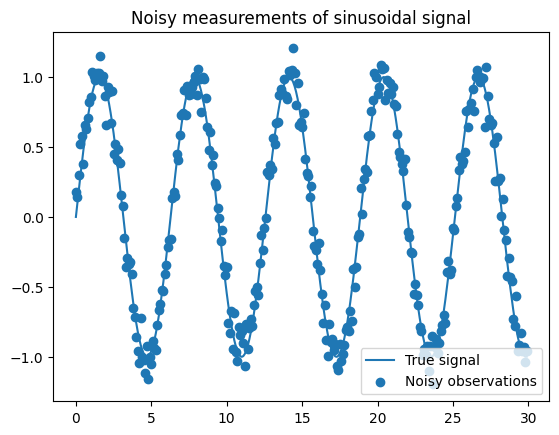

In [6]:
plt.title("Noisy measurements of sinusoidal signal")
plt.plot(ts, sines, label="True signal")
plt.scatter(ts, sin_obs, label="Noisy observations")
plt.legend()

Let us now run a Kalman filter on the data

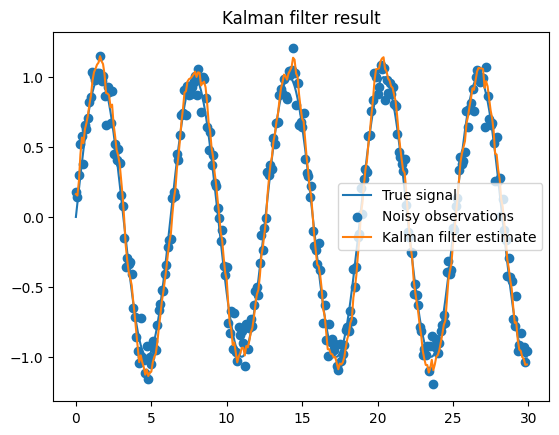

In [7]:
# Initialise the arrays to store the results
filtered_means = np.empty((T, 2))
filtered_covs = np.empty((T, 2, 2))

predicted_means = np.empty((T, 2))
predicted_covs = np.empty((T, 2, 2))

for i in range(T):
    t = ts[i]
    y = sin_obs[i]

    # Kalman filter prediction
    m, P = kf_predict(m, P, A, Q)
    predicted_means[i] = m
    predicted_covs[i] = P

    # Kalman filter update
    m, P = kf_update(m, P, y, H, R)
    filtered_means[i] = m
    filtered_covs[i] = P

plt.title("Kalman filter result")
plt.plot(ts, sines, label="True signal")
plt.scatter(ts, sin_obs, label="Noisy observations")
plt.plot(ts,filtered_means[:,0], label="Kalman filter estimate")
plt.legend()

In [8]:
print(f"The RMSE of the filtering solution compared to the true data is {np.mean((filtered_means[:, 0] - sines) ** 2) ** 0.5:.3f}")

The RMSE of the filtering solution compared to the true data is 0.082


In [9]:
print(f"Simply using the observations would result in {np.mean((sin_obs - sines) ** 2) ** 0.5:.3f}")

Simply using the observations would result in 0.100


Run Rauch-Tung-Striebel smoother on the data.

In [10]:
# Initialise the arrays to store the results
smoothed_means = np.empty((T, 2))
smoothed_covs = np.empty((T, 2, 2))

m = smoothed_means[-1] = filtered_means[-1]
P = smoothed_covs[-1] = filtered_covs[-1]

for i in range(T-2, -1, -1):
    t = ts[i]
    m_filtered = filtered_means[i]
    P_filtered = filtered_covs[i]

    m, P = rts_update(m, P, m_filtered, P_filtered, A, Q)
    smoothed_means[i] = m
    smoothed_covs[i] = P


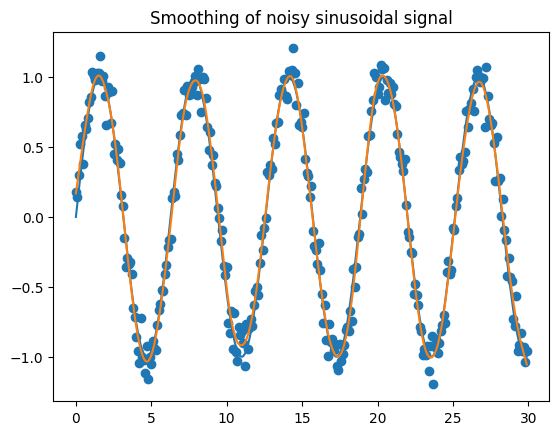

In [11]:
plt.title("Smoothing of noisy sinusoidal signal")
plt.plot(ts, sines, label="True signal")
plt.scatter(ts, sin_obs, label="Noisy observations")
plt.plot(ts,smoothed_means[:,0], label="RTS smoother estimate")

In [12]:
print(f"The RMSE of the smoothing solution compared to the true data is {np.mean((smoothed_means[:, 0] - sines) ** 2) ** 0.5:.3f}")

The RMSE of the smoothing solution compared to the true data is 0.037


## Your turn.

### (a)
Consider the following state space model:
\begin{align}
        \vec{x}_k &= \begin{pmatrix}
                            1 & 1 \\ 0 & 1
        \end{pmatrix}
        \vec{x}_{k-1} + \vec{w}_{k-1} \\
        y_k &= \begin{pmatrix}
                    1 & 0
        \end{pmatrix} \, \vec{x}_k + v_k
\end{align}

where $\vec{x}_k = (x_k~\dot{x}_k)^\top$ is the state, $y_k$ is the
measurement, and $\vec{w}_k \sim \mathcal{N}(\vec{0},\mathrm{diag}(1/10^2,1^2))$ and $v_k
\sim \mathcal{N}(0,10^2)$ are white Gaussian noise processes.

Simulate a 100 step state sequence from the model and plot the
signal $x_k$, signal derivative $\dot{x}_k$ and the simulated
measurements $y_k$. Start from an initial state drawn from a zero-mean
2d-Gaussian distribution with identity covariance.

<ipython-input-13-fbb0ef88488c>:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[k] = H @ x[k] + v


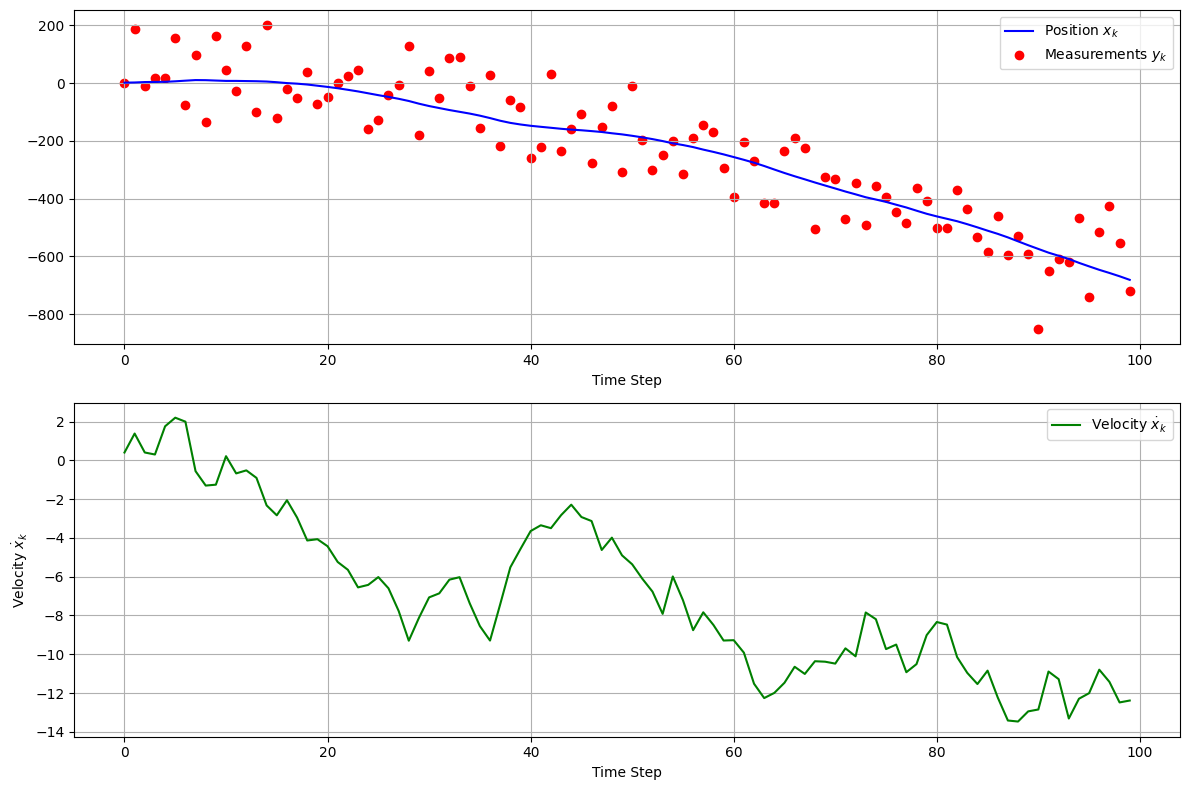

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Define model parameters
A = np.array([[1., 1.], [0., 1.]]) # State transition matrix
H = np.array([[1., 0.]]) # Measurement model matrix

# State transition noise
w_mean = np.array([0., 0.])
w_var = np.diag([1/(10**2), 1**2])
w = np.array([0., 0.])

# Measurement noise
v_mean = 0
v_var = np.array([[10**2]])
v = 0

# SIMULATION

np.random.seed(0)

# Initial state
x0 = np.random.multivariate_normal(mean=np.array([0., 0.]), cov=np.array([[1., 0.], [0., 1.]]))

# Number of time steps
n_steps = 100

# State vector
x = np.zeros((n_steps, 2))
x[0] = x0

# Measurement vector
y = np.zeros(n_steps)

for k in range(1, n_steps):

  w = np.random.multivariate_normal(mean=w_mean, cov=w_var)
  v = np.random.normal(loc=v_mean, scale=v_var)

  x[k] = A @ x[k-1] + w
  y[k] = H @ x[k] + v

# Plotting
plt.figure(figsize=(12, 8))

# Plot position x_k and noisy measurements y_k
plt.subplot(2, 1, 1)
plt.plot(range(n_steps), x[:, 0], label='Position $x_k$', color='blue')
plt.scatter(range(n_steps), y, label='Measurements $y_k$', color='red')
plt.xlabel('Time Step')
plt.grid(True)
plt.legend()

# Plot velocity \dot{x}_k
plt.subplot(2, 1, 2)
plt.plot(range(n_steps), x[:, 1], label='Velocity $\dot{x}_k$', color='green')
plt.xlabel('Time Step')
plt.ylabel('Velocity $\dot{x}_k$')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### (b)
Use the Kalman filter for computing the state estimates.

Hint:
This corresponds to writing a loop around the two functions
```python
# initialize the mean and the covariance
m = ...
P = ...
for ...
    m, P = kf_predict(...)
    m, P = kf_update(...)
    # Store the result
```
already defined in a cell above on the output of the data generating process you have coded in **(a)**.

In [14]:
m = np.array([0., 0.])
P = np.diag([0.1, 1.])

# Notating process and measurement noises for better context
Q = w_var
R = v_var

predicted_means = np.empty((n_steps, 2))
predicted_covs = np.empty((n_steps, 2, 2))

filtered_means = np.empty((n_steps, 2))
filtered_covs = np.empty((n_steps, 2, 2))

for k in range(1,n_steps):

    # Prediction step
    m, P = kf_predict(m, P, A, Q)
    predicted_means[k] = m
    predicted_covs[k] = P

    # Update step
    m, P = kf_update(m, P, y[k], H, R)
    filtered_means[k] = m
    filtered_covs[k] = P

### (c)
Plot the state estimates $\vec{m}_k$, the true states $\vec{x}_k$ and measurements $y_k$ using [Matplotlib](https://matplotlib.org/)

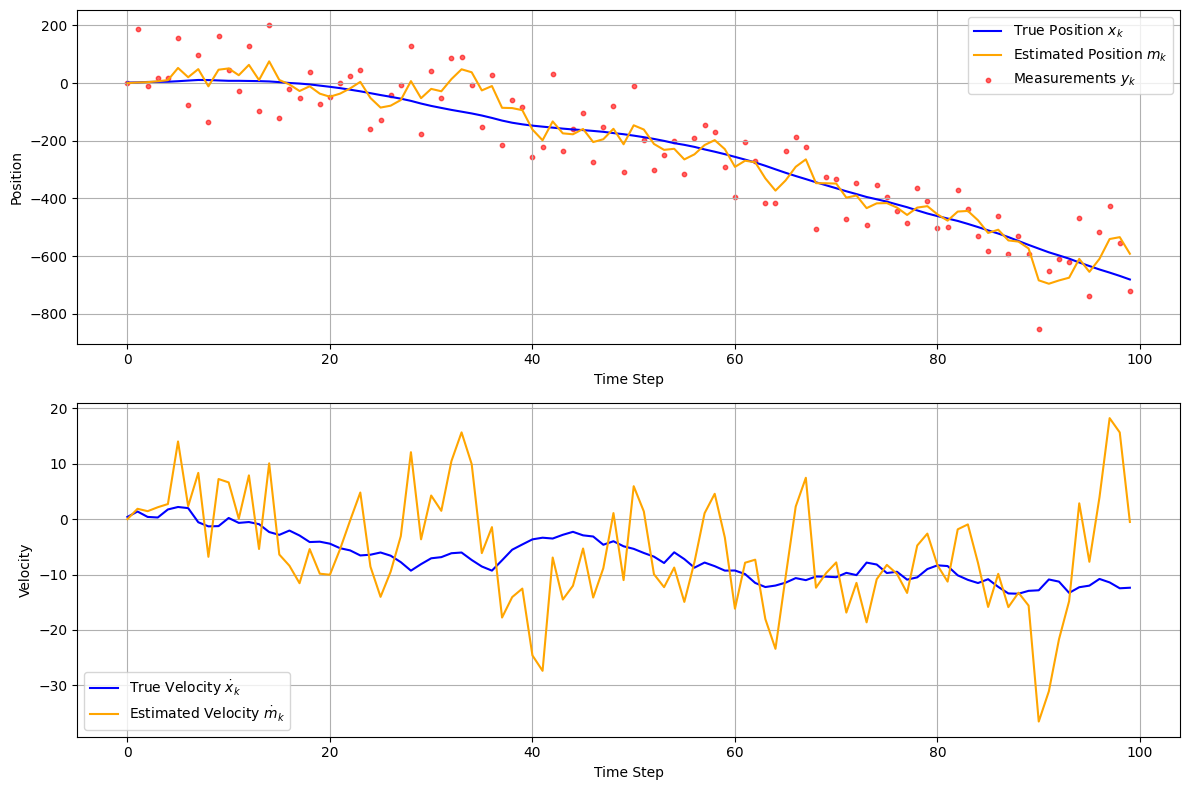

In [15]:
# Plotting results
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Plot true position, estimated position, and measurements
ax[0].plot(range(n_steps), x[:, 0], label='True Position $x_k$', color='blue')
ax[0].plot(range(n_steps), filtered_means[:, 0], label='Estimated Position $m_k$', color='orange')
ax[0].scatter(range(n_steps), y, label='Measurements $y_k$', color='red', s=10, alpha=0.6)
ax[0].set_xlabel('Time Step')
ax[0].set_ylabel('Position')
ax[0].legend()
ax[0].grid(True)

# Plot true velocity and estimated velocity
ax[1].plot(range(n_steps), x[:, 1], label='True Velocity $\dot{x}_k$', color='blue')
ax[1].plot(range(n_steps), filtered_means[:, 1], label='Estimated Velocity $\dot{m}_k$', color='orange')
ax[1].set_xlabel('Time Step')
ax[1].set_ylabel('Velocity')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()



### (d)
Compute the RMSE (root mean square error) of using the first components of vectors $\vec{m}_k$ as the estimates of first
components of states $\vec{x}_k$. Also compute the RMSE error that we would
have if we used the measurements as the estimates.

In [16]:
# RMSE between Kalman estimates and true position
rmse_kalman = np.sqrt(np.mean((x[:, 0] - filtered_means[:, 0]) ** 2))

print(f"RMSE of Kalman estimates: {rmse_kalman:.4f}")


# RMSE between measurements and true position
rmse_measurements = np.sqrt(np.mean((x[:, 0] - y) ** 2))

print(f"RMSE of measurements: {rmse_measurements:.4f}")

RMSE of Kalman estimates: 48.1465
RMSE of measurements: 98.6949
